# Language prediction

Predict the language of one article by using the topics vector with K = 40.

In [1]:
import pandas as pd

ci = pd.read_json("predict_lang/ci.json", lines=True)
ci = ci[ci.k==40].drop_duplicates()
ci['feature'] = ci['feature'].apply(lambda r: r.replace("_log", ""))
ci.head()

,feature,left,right,coeff,k,site
0,topic39,-0.532936,-0.497706,-0.515321,40,enwiki
1,topic3,-0.147987,-0.125496,-0.136741,40,enwiki
2,topic14,-0.128713,-0.101084,-0.114898,40,enwiki
3,topic37,-0.117377,-0.081162,-0.099270,40,enwiki
4,topic6,-0.109899,-0.079551,-0.094725,40,enwiki


In [2]:
predictions = pd.read_json("predict_lang/predict_language.json", lines=True)
predictions = predictions[predictions.k==40]

predictions.head()

,y_test,y_pred,k,site
0,0,0.291037,40,enwiki
1,1,0.838948,40,enwiki
2,0,0.642596,40,enwiki
3,0,0.349320,40,enwiki
4,1,0.400401,40,enwiki


In [ ]:
languages = {"enwiki": "English", "eswiki": "Spanish", "itwiki": "Italian", "dewiki": "German", 
             "frwiki": "French", "cswiki": "Czech", "cawiki": "Catalan", "svwiki": "Swedish", 
             "arwiki": "Arabic", "elwiki": "Greek", "fiwiki": "Finnish", "hewiki": "Hebrew",
             "idwiki": "Indonesian", "kowiki": "Korean", "nlwiki": "Dutch", "plwiki": "Polish", 
             "ptwiki": "Portuguese", "rowiki": "Romanian", "ruwiki": "Russian", "sqwiki": "Albanian", 
             "srwiki": "Serbian", "trwiki": "Turkish", "ukwiki": "Ukrainian", "viwiki": "Vietnamese",
             "warwiki": "Waray", "zhwiki": "Chinese", "fawiki": "Persian", "jawiki": "Japanese"}

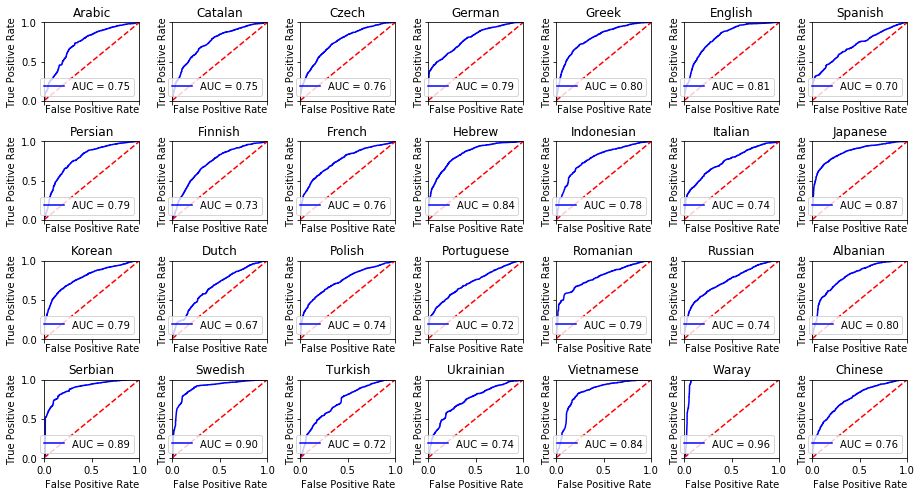

In [8]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

sites = sorted(predictions.site.unique())

cols = 7

f, axes = plt.subplots(len(sites)//cols, cols, figsize=(13, 7), sharex=True, sharey=True)

for idx in range(len(sites)):
    site = sites[idx]
    current_site = predictions[predictions.site==site]
    fpr, tpr, threshold = metrics.roc_curve(current_site.y_test, current_site.y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    ax = axes[idx//cols][idx%cols]
    ax.set_title(languages[site])
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    
f.tight_layout()

In [1]:
labels_list = """Biochemistry, medicine
UK-Ireland
Arthropods
Comics
Math, physics
France
Soccer, programming
Soccer, cricket
Poland, Vietnam
Italy
Species
Climate
Middle East conflicts
Middle East history
Baltic region
Pop & rock music
Plants
Balkans, Catholicism
Canada
World War II (Europe)
Women’s tennis
Ice hockey
Computing
Romania, UK soccer
Iran, India, car racing, aeronautics 
Men’s tennis
Classic & jazz music
Car racing, baseball
USA
Brazil, Portugal, Ukraine
Basketball
Climate, video games
French history
Russia, Eastern Europe
Mexico, soccer
Germany
Astronomy
German politics, sports
World War II (Asia)
Spain, Latin America""".split("\n")

labels = {}
for i in range(len(labels_list)):
    labels[i+1]=(labels_list[i][:22] + '...') if len(labels_list[i]) > 25 else labels_list[i]

ci['label']=ci.feature.apply(lambda r: labels[int(r.replace("topic", ""))])

------
# AUC by language

In [9]:
from sklearn.metrics import roc_auc_score

sites = predictions.site.unique()

auc_list = []
for idx in range(len(sites)):
    site = sites[idx]
    current_site = predictions[predictions.site==site]
    score = roc_auc_score(current_site.y_test, current_site.y_pred)
    auc_list.append({"auc": score, "site": site})
    
auc = pd.DataFrame(auc_list)
auc

,auc,site
0,0.814052,enwiki
1,0.704550,eswiki
2,0.744593,itwiki
3,0.790310,dewiki
4,0.757783,frwiki
5,0.758401,cswiki
6,0.750285,cawiki
7,0.898347,svwiki
8,0.746663,arwiki
9,0.799874,elwiki


### Average AUC

In [10]:
auc.mean()

auc    0.782607
dtype: float64

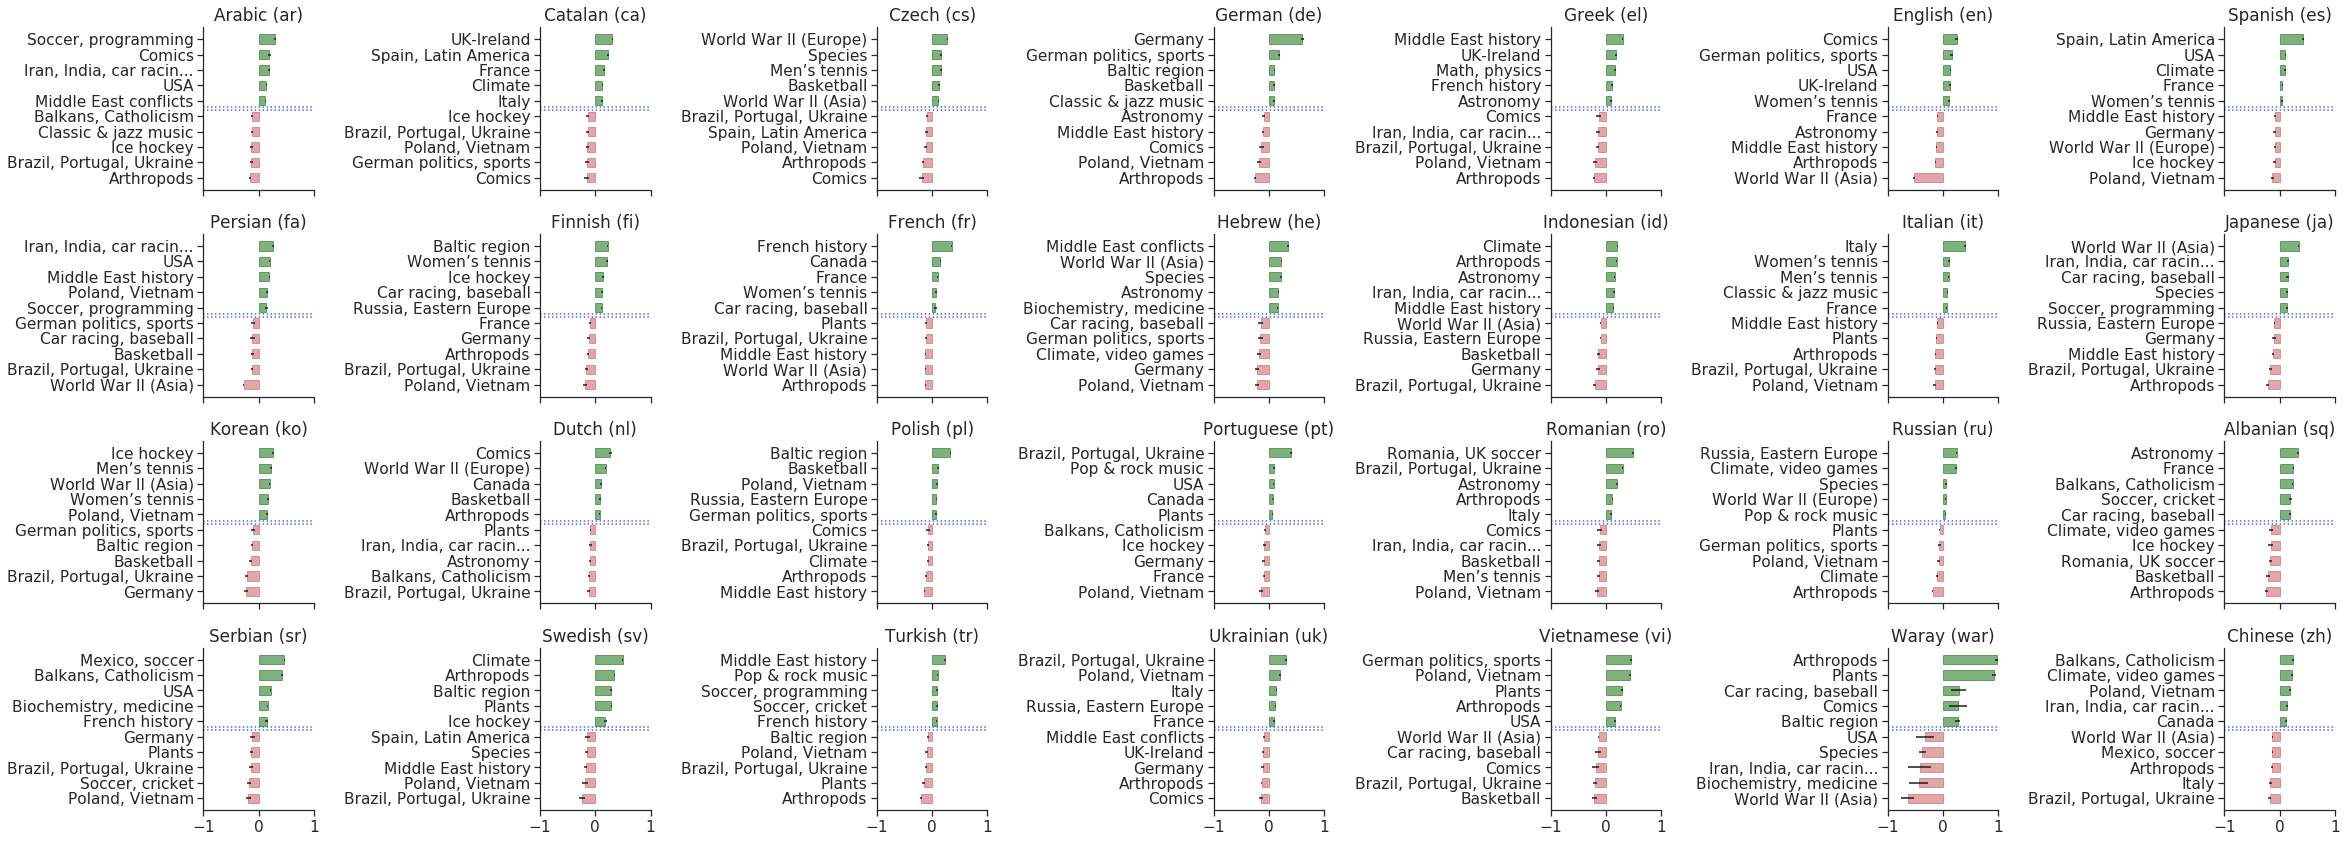

In [19]:
sns.set_context("paper")
sns.set(font_scale = 1.4)
sns.set_style("white", {
    "font.family": "monospace",
    "font.serif": ['monospace'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

sites = predictions.site.unique()
sites_limited = sorted(sites)

cols = 7

f, axes = plt.subplots(len(sites_limited)//cols, cols, figsize=(33, 12), sharex=True, sharey=False)


for idx in range(len(sites_limited)):
    site = sites_limited[idx]
    ax = axes[idx//cols][idx%cols]
    ci_lang = ci[ci.site==site].sort_values("coeff")
    top_bottom = ci_lang.tail(5).append(ci_lang.head(5)).sort_values("coeff").reset_index(drop=True)
    err = []
    for idx, row in top_bottom.iterrows():
        err.append(row['left']-row['coeff'])

    barlist = ax.barh(top_bottom.label, top_bottom.coeff, xerr=err, alpha=0.5, height=0.6)
    for i in range(5):
        barlist[i].set_color('r')
    for i in range(5, 10):
        barlist[i].set_color('darkgreen')
    ax.axhline(y=4.4, linestyle='dotted', color="royalblue")
    ax.axhline(y=4.6, linestyle='dotted', color="royalblue")
    ax.set_xlim((-1,1))
    ax.set_title("{} ({})".format(languages.get(site), site.replace("wiki","")))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()

plt.savefig("langpred_features_labels_28.pdf", bbox_inches = 'tight', pad_inches = 0)